In [1]:
import sys
# sys.path.insert(0, '/home/student.unimelb.edu.au/shorte1/Documents/TINT')
# sys.path.insert(0, '/home/563/esh563/TINT/')

import xarray as xr
import numpy as np
%pdb
import matplotlib.pyplot as plt
import copy
import pandas as pd
import classification as cl
import soundings as sd

%load_ext autoreload
%autoreload 1
%aimport soundings

Automatic pdb calling has been turned ON

## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [ ]:
# ERA5_soundings = sd.get_ERA5_soundings()

In [ ]:
# ERA5_soundings.to_netcdf('ERA5_soundings.nc')

In [23]:
ERA5_soundings = xr.open_dataset('ERA5_soundings.nc')
ACCESS_G_soundings = xr.open_dataset('ACCESS_G_soundings.nc')

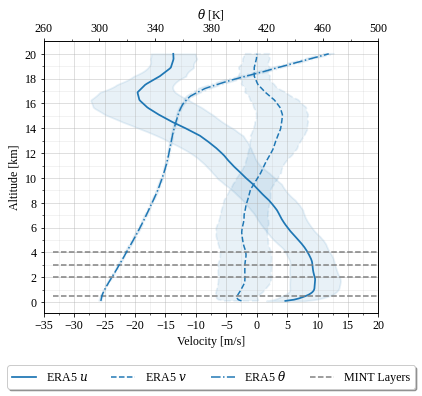

In [24]:
sd.plot_soundings(ACCESS_G_soundings)

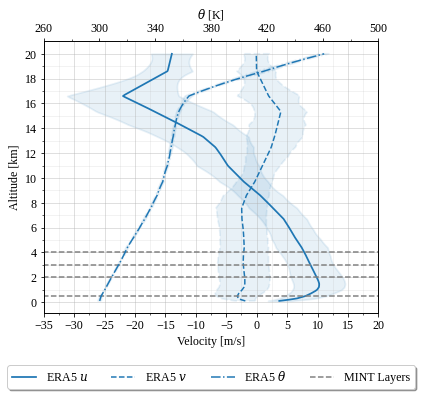

In [25]:
sd.plot_soundings(ERA5_soundings)

In [ ]:
days_2021 = np.arange(
    np.datetime64('2021-01-01'), np.datetime64('2021-03-01'),
    np.timedelta64(1, 'D'))
days_2022 = np.arange(
    np.datetime64('2022-01-01'), np.datetime64('2022-03-01'),
    np.timedelta64(1, 'D'))
days_list = [days_2021, days_2022]
           
bad_days_list = [
    np.datetime64('2021-01-12'),
    np.datetime64('2022-01-06')]

days = sorted(list(set(np.concatenate(days_list)) - set(bad_days_list)))

pope_df = pd.read_csv(
    'fake_pope_regimes.csv', header=None,
    index_col=0, names=['time', 'pope_regime'])
pope_df.index = pd.to_datetime(pope_df.index)

lon = 130.925
lat = -12.457

base_dir = '/g/data/wr45/ops_aps3/access-dn/1/'

years = [2021, 2022]

hours = [0, 6, 12, 18]

soundings_ds = [[] for i in range(len(hours))]

topog = xr.open_dataset('/g/data/wr45/ops_aps3/access-dn/1/20201001/0000/an/sfc/topog.nc')
topog = topog.interp(lon=lon, lat=lat)

for i in range(len(days)):
    
    print('Loading {}'.format(days[i]))
              
    for j in range(len(hours)):
            
        datetime_str = days[i].astype(str).replace('-', '')

        year = datetime_str[0:4]
        month = datetime_str[4:6]
        day = datetime_str[6:8]
        
        date_str = '{}{}{}'.format(year, month, day)
        hour_str = '{:02d}00'.format(hours[j])

        datasets = []
        for var in ['wnd_ucmp', 'wnd_vcmp', 'air_temp', 'pressure']:

            ds = xr.open_dataset(
                base_dir + '{}/{}/an/ml/{}.nc'.format(date_str, hour_str, var))
                    
            ds = ds.interp(lon=lon, lat=lat)
            ds = ds.load()

            datasets.append(ds)

        [u_t, v_t, t_t, p_t] = datasets
        
#         import pdb; pdb.set_trace()
        altitude_rho = u_t.A_rho + u_t.B_rho * topog['topog']
        altitude_theta = p_t.A_theta + p_t.B_theta * topog['topog']
        
        u_t = u_t.rename({'rho_lvl': 'altitude'})
        v_t = v_t.rename({'rho_lvl': 'altitude'})
        t_t = t_t.rename({'theta_lvl': 'altitude'})
        p_t = p_t.rename({'theta_lvl': 'altitude'})

        u_t = u_t['wnd_ucmp'].assign_coords({'altitude': altitude_rho.squeeze().values})
        v_t = v_t['wnd_vcmp'].assign_coords({'altitude': altitude_rho.squeeze().values})
        t_t = t_t['air_temp'].assign_coords({'altitude': altitude_theta.squeeze().values})
        p_t = p_t['pressure'].assign_coords({'altitude': altitude_theta.squeeze().values})
        ds_t = xr.Dataset({
            'u': u_t, 'v': v_t,
            'p': p_t, 't': t_t})

        ds_t = ds_t.sel(altitude=slice(0, 25e3))
        
        new_alts = np.arange(100, 20100, 100)
        ds_t = ds_t.interp(altitude=new_alts)

        ds_t['time'] = ds_t['time'] - np.timedelta64(hours[j], 'h')

        ds_t['pope_regime'] = pope_df.loc[ds_t['time'].values]

        soundings_ds[j].append(ds_t)
    
new_ds = []

for i in range(len(hours)):
    ds_i = xr.concat(soundings_ds[i], dim='time')
    ds_i = ds_i.drop('dim_0')
    ds_i = ds_i.squeeze()
    new_ds.append(ds_i)

hours_da = xr.DataArray(hours, name='hour', coords={'hour': hours})

ACCESS_G_soundings = xr.concat(new_ds, dim=hours_da)

R = 287.04
cp = 1005

ACCESS_G_soundings['theta'] = ACCESS_G_soundings['t']*(
    1e3/ACCESS_G_soundings['p'])**(R/cp)

Loading 2021-01-01
Loading 2021-01-02
Loading 2021-01-03
Loading 2021-01-04
Loading 2021-01-05
Loading 2021-01-06
Loading 2021-01-07
Loading 2021-01-08
Loading 2021-01-09
Loading 2021-01-10
Loading 2021-01-11
Loading 2021-01-13
Loading 2021-01-14
Loading 2021-01-15
Loading 2021-01-16
Loading 2021-01-17
Loading 2021-01-18
Loading 2021-01-19
Loading 2021-01-20
Loading 2021-01-21
Loading 2021-01-22
Loading 2021-01-23
Loading 2021-01-24
Loading 2021-01-25
Loading 2021-01-26
Loading 2021-01-27
Loading 2021-01-28
Loading 2021-01-29
Loading 2021-01-30
Loading 2021-01-31
Loading 2021-02-01
Loading 2021-02-02
Loading 2021-02-03
Loading 2021-02-04
Loading 2021-02-05
Loading 2021-02-06
Loading 2021-02-07
Loading 2021-02-08
Loading 2021-02-09
Loading 2021-02-10
Loading 2021-02-11
Loading 2021-02-12
Loading 2021-02-13
Loading 2021-02-14
Loading 2021-02-15
Loading 2021-02-16
Loading 2021-02-17
Loading 2021-02-18
Loading 2021-02-19
Loading 2021-02-20
Loading 2021-02-21
Loading 2021-02-22
Loading 2021

In [ ]:
ACCESS_G_soundings.to_netcdf('ACCESS_G_soundings.nc')